In [84]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [85]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet18FeatureExtractor, self).__init__()
        self.resnet18 = models.resnet18(weights=True)
        self.feature_extractor = nn.Sequential(*list(self.resnet18.children())[:-2])

    def forward(self, x):
        features = self.feature_extractor(x)
        return features

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure the image has 3 channels (RGB)
    image = preprocess(image)
    image = image.unsqueeze(0)
    return image

def extract_features(image_path1, image_path2, model):
    I1 = load_and_preprocess_image(image_path1)
    I2 = load_and_preprocess_image(image_path2)

    with torch.no_grad():
        F1 = model(I1)
        F2 = model(I2)

    return F1, F2

def visualize_feature_map(feature_map, num_channels=8):
    # Convert feature map to numpy
    feature_map_np = feature_map.squeeze().cpu().numpy()

    # Plot a subset of channels
    plt.figure(figsize=(16, 8))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(feature_map_np[i, :, :], cmap='viridis')
        plt.axis('off')
    plt.show()


preprocess = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size=1):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # Linear projection layer
        self.projection = nn.Linear(in_channels * patch_size * patch_size, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        # Ensure the patch size divides H and W
        assert H % self.patch_size == 0 and W % self.patch_size == 0, \
            f"Patch size {self.patch_size} must divide both H ({H}) and W ({W})"

        # Extract patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, -1, C * self.patch_size * self.patch_size)  # Reshape patches
        tokens = self.projection(patches)
        return tokens

class PositionalEmbedding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEmbedding, self).__init__()
        # Create a learnable parameter for the positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # Ensure that the input tokens (x) have the same number of patches as the positional embeddings
        assert x.size(1) == self.pos_embedding.size(1), \
            f"Number of patches ({x.size(1)}) does not match the number of positional embeddings ({self.pos_embedding.size(1)})"
        return x + self.pos_embedding

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, D = x.size()
        q = self.query(x).view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        k = self.key(x).view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        v = self.value(x).view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)

        # Calculate attention weights and apply them to value vectors
        attn = (q @ k.transpose(-2, -1)) / (D ** 0.5)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        output = (attn @ v).transpose(1, 2).contiguous().view(B, N, D)
        return self.out(output)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, context):
        B, N, D = x.size()
        q = self.query(x).view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        k = self.key(context).view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        v = self.value(context).view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)

        # Calculate cross-attention weights
        attn = (q @ k.transpose(-2, -1)) / (D ** 0.5)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        output = (attn @ v).transpose(1, 2).contiguous().view(B, N, D)
        return self.out(output)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.cross_attn = CrossAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, forward_dim),
            nn.ReLU(),
            nn.Linear(forward_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context):
        # Self-Attention Layer
        x = x + self.dropout(self.self_attn(self.norm1(x)))
        # Cross-Attention Layer
        x = x + self.dropout(self.cross_attn(self.norm2(x), context))
        # Feed-Forward Network
        x = x + self.dropout(self.ffn(self.norm3(x)))
        return x


class ViT(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size, num_heads, num_layers, forward_dim, dropout=0.1):
        super(ViT, self).__init__()
        # Calculate number of patches dynamically
        num_patches = 80 # 7 * 7 = 49 patches for your feature maps
        self.patch_embedding = PatchEmbedding(in_channels, embed_dim, patch_size)
        self.pos_embedding = PositionalEmbedding(num_patches=num_patches, embed_dim=embed_dim)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, forward_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, F1, F2):
        tokens1 = self.patch_embedding(F1)
        tokens2 = self.patch_embedding(F2)
        tokens1 = self.pos_embedding(tokens1)
        tokens2 = self.pos_embedding(tokens2)

        for layer in self.transformer_layers:
            tokens1 = layer(tokens1, tokens2)  # Cross-attention between F1 and F2
            tokens2 = layer(tokens2, tokens1)  # Cross-attention between F2 and F1

        return tokens1, tokens2  # Transformed features F1' and F2'


In [87]:
feature_extractor = ResNet18FeatureExtractor()

image_path1 = 'L3SF_V2/L3-SF\R1/1_1_1.png'
image_path2 = 'L3SF_V2/L3-SF\R1/3_1_1.png'

F1, F2 = extract_features(image_path1, image_path2, feature_extractor)

patch_size = 1  # We are using a patch size of 1

vit_model = ViT(in_channels=512, embed_dim=256, patch_size=patch_size, num_heads=4, num_layers=6, forward_dim=512)
F1_prime, F2_prime = vit_model(F1, F2)


print("Feature vector for Image 1:", F1)
print("Feature vector for Image 2:", F2)
print("Transformed feature map for F1':", F1_prime.shape)
print("Transformed feature map for F2':", F2_prime.shape)

Feature vector for Image 1: tensor([[[[0.3326, 3.2213, 3.8619,  ..., 0.0000, 0.0000, 0.0000],
          [1.7199, 4.4104, 3.9386,  ..., 0.4629, 0.0000, 0.0000],
          [0.6975, 1.3382, 1.2219,  ..., 0.9513, 0.9959, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 3.1514, 4.1428, 1.9260],
          [0.0000, 0.0000, 0.0000,  ..., 1.1712, 0.5709, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.5665, 0.0000, 0.0000]],

         [[0.0000, 0.8206, 0.4240,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 2.1412, 1.4694,  ..., 0.1195, 0.0000, 0.0000],
          [0.8695, 3.3188, 3.2978,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.9054,  ..., 2.8633, 3.2471, 1.9962],
          [0.0000, 0.0000, 0.6533,  ..., 2.4520, 2.8754, 0.9942],
          [0.0000, 0.0000, 0.0000,  ..., 1.7161, 1.9010, 0.3505]],

         [[0.1063, 1.1360, 0.5008,  ..., 0.3269, 0.2850, 0.0000],
          [1.1474, 3.9436, 3.6341,  ..., 1.0537, 0.0578, 0.0000],
          [1.1

In [88]:
def calculate_correlation(F1_prime, F2_prime):
    # F1_prime and F2_prime are of shape [B, H*W, D]
    B, N, D = F1_prime.size()  # N = H * W, D = embedding dimension

    # Calculate correlation matrix C
    correlation = torch.bmm(F1_prime, F2_prime.transpose(1, 2)) / (D ** 0.5)
    return correlation  # Shape [B, N, N]

correlation_matrix = calculate_correlation(F1_prime, F2_prime)
print("Correlation matrix:", correlation_matrix.shape)

Correlation matrix: torch.Size([1, 80, 80])


In [89]:
def dual_softmax(correlation_matrix):
    # Apply softmax along rows
    P_row = F.softmax(correlation_matrix, dim=-1)
    # Apply softmax along columns
    P_col = F.softmax(correlation_matrix.transpose(1, 2), dim=-1).transpose(1, 2)
    # Element-wise multiplication of row and column softmax results
    P = P_row * P_col
    return P  # Shape [B, N, N]

def filter_matches(P, threshold=0.5):
    # Find matches with confidence score >= T1
    matches = (P >= threshold).nonzero(as_tuple=False)
    return matches  # Tensor of match indices (i, j) in P that exceed threshold

def mutual_nearest_neighbor(P, matches):
    # MNN filtering
    mutual_matches = []
    for match in matches:
        i, j = match[1], match[2]  # Coordinates in the flattened matrix
        # Check if the highest match for i in F1' corresponds to j in F2'
        if P[:, i, :].argmax(dim=-1) == j and P[:, :, j].argmax(dim=-1) == i:
            mutual_matches.append((i.item(), j.item()))
    return mutual_matches  # List of mutual matches (i, j)

def dense_pixel_matching(F1_prime, F2_prime, threshold=0.5):
    # Step 1: Calculate the correlation matrix
    C = calculate_correlation(F1_prime, F2_prime)
    # print(C)
    # Step 2: Normalize using dual-softmax to obtain the matching confidence matrix P
    P = dual_softmax(C)
    # print(P)
    # Step 3: Filter matches based on the confidence threshold
    matches = filter_matches(P, threshold)

    # Step 4: Apply Mutual-Nearest-Neighbor (MNN) filtering
    final_matches = mutual_nearest_neighbor(P, matches)

    return final_matches

In [90]:
threshold = 0.5  # Confidence threshold for match selection
matches = dense_pixel_matching(F1_prime, F2_prime, threshold)

print("Final matched coordinates:", matches)

Final matched coordinates: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79)]


# **Module 1 Architecture:**
1 -> ResNet18 -> F1 -> ViT -> F1' -> Dense-pixel-matching

2 -> ResNet18 -> F2 -> ViT -> F2' -> Dense-pixel-matching


# **Training ViT:**

1. Negative Log-Likelihood Loss Computation

  *   The loss function Ld is defined based on the matching confidence matrix P, which provides a pixel-wise match probability.
  *   Ggt is the set of ground truth pixel correspondences between orignial and corrupted fingerprint images

2. Synthetic Noise Generation

  *   Simulate real world conditions and improve robustness add noise using Perlin noise, erosion and dilation.              
  *   Each corrupted fingerprint image is randomly rotated within 60 degrees to simulate variations in positioning on the sensor.

3. Pre Trained ViT Model

  *   Use a pre-trained ViT to initialize ViT for faster convergence during training.



In [91]:
import numpy as np

def random_rotate(image, angle_range=60):
    angle = np.random.uniform(-angle_range, angle_range)
    rotated_image = image.rotate(angle)
    return rotated_image, angle



In [92]:
import math

def create_ground_truth_matrix(original_image, angle, patch_dim_H=8, patch_dim_W=10):
    # Image dimensions
    H, W = original_image.shape[-2], original_image.shape[-1]
    
    # Calculate patch size
    patch_size_H = H // patch_dim_H # 30
    patch_size_W = W // patch_dim_W # 32
    
    # Number of patches
    num_patches = patch_dim_H * patch_dim_W # 80 

    # Initialize the ground truth matrix with zeros
    ground_truth_matrix = torch.zeros((num_patches, num_patches), dtype=torch.int) # 80x8
    # Calculate the center coordinates of the image (for rotation purposes)
    center_x = W / 2
    center_y = H / 2

    # Calculate the center coordinates of each patch in the original image
    patch_centers = []
    for i in range(patch_dim_H):
        for j in range(patch_dim_W):
            cx = j * patch_size_W + patch_size_W / 2
            cy = i * patch_size_H + patch_size_H / 2
            patch_centers.append((cx, cy))
    
    # Convert rotation angle to radians
    angle_rad = math.radians(angle)

    # Map each patch center after rotation to a patch in the corrupted image
    for orig_idx, (x, y) in enumerate(patch_centers):
        # Translate patch center to origin for rotation
        x_shifted, y_shifted = x - center_x, y - center_y

        # Apply rotation
        x_rot = x_shifted * math.cos(angle_rad) - y_shifted * math.sin(angle_rad)
        y_rot = x_shifted * math.sin(angle_rad) + y_shifted * math.cos(angle_rad)

        # Translate back to image coordinates
        x_rot += center_x
        y_rot += center_y

        x_rot = int(x_rot//patch_size_W)
        y_rot = int(y_rot//patch_size_H)
        
        if x_rot >= 0 and x_rot < patch_dim_W and y_rot >= 0 and y_rot < patch_dim_H:
            # Calculate the patch index in the corrupted image
            corr_idx = y_rot * patch_dim_W + x_rot

            # Set the ground truth matrix
            ground_truth_matrix[orig_idx, corr_idx] = 1
        
    # print(angle)
        


    return ground_truth_matrix


# Example
original_image = torch.zeros((240, 320)) 
rotation_angle = 30 
ground_truth_matrix = create_ground_truth_matrix(original_image, rotation_angle)

print(ground_truth_matrix.shape)


torch.Size([80, 80])


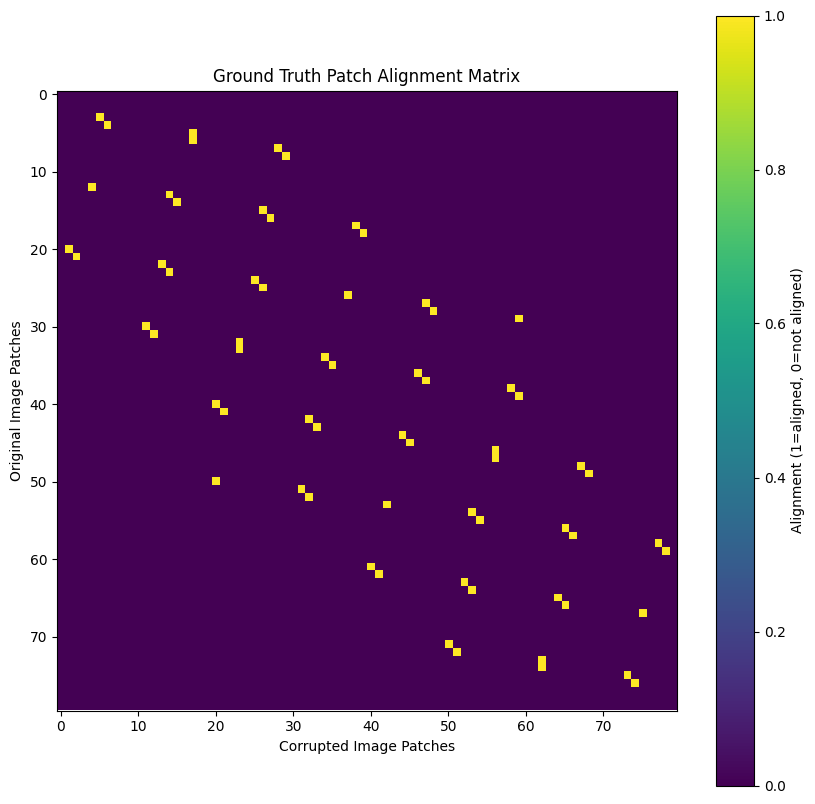

In [93]:
import matplotlib.pyplot as plt

# Assuming ground_truth_matrix is the 80x80 matrix we want to visualize
plt.figure(figsize=(10, 10))  # Set the figure size for better visibility
plt.imshow(ground_truth_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Alignment (1=aligned, 0=not aligned)')
plt.title("Ground Truth Patch Alignment Matrix")
plt.xlabel("Corrupted Image Patches")
plt.ylabel("Original Image Patches")
plt.show()

Prepare Dataset

Get ground truths.

Loss Function Implementaiton

In [94]:
import torch
import torch.nn.functional as F

def dense_registration_loss(P, G_gt, device='cuda'):
    """
    Compute the dense registration loss using negative log-likelihood for patch alignments.

    Parameters:
    - P (torch.Tensor): Confidence matrix (before softmax), shape [B, 80, 80].
    - G_gt (torch.Tensor): Ground truth binary matching matrix, shape [B, 80, 80].
    - device (str): Device to perform computations ('cuda' or 'cpu').

    Returns:
    - torch.Tensor: Computed dense registration loss.
    """
    
    log_P = torch.log(P + 1e-8)  # Shape [B, 80, 80]

    # Select log-probabilities for the correct matches only
    selected_log_prob = log_P * G_gt  # Element-wise multiplication
    loss = -selected_log_prob.sum() / G_gt.sum()  # Average negative log-likelihood over matches

    return loss

TRAINING LOOP

In [ ]:
# import os
# import torch
# from PIL import Image
# from torchvision import transforms

# # Define paths and transformation
# data_root = "L3SF-Model"
# processed_data_dir = "Processed_L3SF_Model"
# os.makedirs(processed_data_dir, exist_ok=True)

# transform = transforms.Compose([
#     transforms.Resize((240, 320)),  # Standardize image size
#     transforms.ToTensor()
# ])

# # Preprocess original and corrupted images
# for subdir in ["original", "corrupted"]:
#     input_dir = os.path.join(data_root, subdir)
#     output_dir = os.path.join(processed_data_dir, subdir)
#     os.makedirs(output_dir, exist_ok=True)

#     for img_name in os.listdir(input_dir):
#         img_path = os.path.join(input_dir, img_name)
#         image = Image.open(img_path).convert("L")
        
#         # Apply transformations and save as tensor
#         tensor_image = transform(image)
#         tensor_path = os.path.join(output_dir, f"{img_name}.pt")
#         torch.save(tensor_image, tensor_path)

In [95]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import re
import os


In [96]:
class FingerprintDataset(Dataset):
    def __init__(self, data_root):
        self.original_dir = os.path.join(data_root, "original")
        self.corrupted_dir = os.path.join(data_root, "corrupted")
        
        # Prepare list of (original, corrupted, angle) triplets
        self.image_triplets = []

        # Regex to match the base filename (e.g., `100_1_1`) and angle in corrupted files
        base_pattern = re.compile(r"^(.+)_(-?\d+)\.png\.pt$")
        
        # Load all corrupted file paths in a dictionary by base name
        corrupted_files = {}
        for corrupted_img in os.listdir(self.corrupted_dir):
            match = base_pattern.match(corrupted_img)
            if match:
                base_name, angle = match.groups()
                angle = int(angle)  # Convert angle to an integer
                if base_name not in corrupted_files:
                    corrupted_files[base_name] = []
                corrupted_files[base_name].append((os.path.join(self.corrupted_dir, corrupted_img), angle))
        
        # Match corrupted images based on the original filenames
        for original_img in os.listdir(self.original_dir):
            base_name = original_img.replace(".png.pt", "")
            original_path = os.path.join(self.original_dir, original_img)
            
            # If we find corrupted images with the same base name, create triplets
            if base_name in corrupted_files:
                for corrupted_path, angle in corrupted_files[base_name]:
                    self.image_triplets.append((original_path, corrupted_path, angle))
            else:
                print(f"No corrupted image found for {original_img}")
        
        print(f"Total image triplets found: {len(self.image_triplets)}")

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        original_path, corrupted_path, angle = self.image_triplets[idx]
        
        # Load preprocessed tensors directly
        original_tensor = torch.load(original_path)
        corrupted_tensor = torch.load(corrupted_path)
        
        # Generate the ground truth alignment matrix based on the rotation angle
        ground_truth_matrix = create_ground_truth_matrix(
            original_tensor, angle, patch_dim_H=8, patch_dim_W=10
        )
        
        return original_tensor, corrupted_tensor, ground_truth_matrix



In [97]:
# Initialize dataset with preprocessed data directory and check length
data_root = "Processed_L3SF_Model"
dataset = FingerprintDataset(data_root=data_root)

# Check if dataset has any items
print(f"Total samples in the dataset: {len(dataset)}")



Total image triplets found: 7288
Total samples in the dataset: 7288


In [98]:


# If dataset is not empty, proceed to test DataLoader
if len(dataset) > 0:
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
    
    # Test loading a single batch
    try:
        original_images, corrupted_images, ground_truth_matrices = next(iter(dataloader))

        print(f"Original images shape: {original_images.shape}")   # Expected: [batch_size, 1, 240, 320]
        print(f"Corrupted images shape: {corrupted_images.shape}")  # Expected: [batch_size, 1, 240, 320]
        print(f"Ground truth matrices shape: {ground_truth_matrices.shape}")  # Expected: [batch_size, 80, 80]

    except Exception as e:
        print(f"An error occurred while testing the DataLoader: {e}")
else:
    print("No samples found in the dataset. Please check if the data paths and file structure are correct.")

Original images shape: torch.Size([4, 1, 240, 320])
Corrupted images shape: torch.Size([4, 1, 240, 320])
Ground truth matrices shape: torch.Size([4, 80, 80])


C:\Users\johnm\AppData\Local\Temp\ipykernel_23128\3916111641.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_tensor = torch.load(original_path)
C:\Users\johnm\

Single Training Loop

In [99]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ViT(in_channels=512, embed_dim=256, patch_size=1, num_heads=4, num_layers=6, forward_dim=512).to(device)
feature_extractor = ResNet18FeatureExtractor().to(device)
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)


In [103]:
import numpy as np

def load_and_preprocess_image(image_path):
    # Define transforms
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.ToTensor(),  # Convert to PyTorch tensor (C, H, W)
    ])

    # Load image
    image = Image.open(image_path)

    # Apply transforms
    tensor_image = transform(image)  # Shape: [1, H, W]

    return tensor_image

def random_rotate_tensor(image_tensor, angle_range=60):
    angle = np.random.uniform(-angle_range, angle_range)
    # Convert tensor back to PIL for rotation
    image_pil = transforms.ToPILImage()(image_tensor)
    rotated_pil = image_pil.rotate(angle)
    # Convert back to tensor
    rotated_tensor = transforms.ToTensor()(rotated_pil)
    return rotated_tensor, angle

# Example Usage
image_path = 'L3SF-Model/original/1_1_1.png'  # Replace with your image path
original_image = load_and_preprocess_image(image_path)  # Shape: [1, H, W]

# Rotate the tensor image
corrupted_image, angle = random_rotate_tensor(original_image)

# Create the ground truth matrix
ground_truth = create_ground_truth_matrix(original_image.squeeze(0), angle)

# Print outputs for verification
print("Original Image Tensor Shape:", original_image.shape)
print("Corrupted Image Tensor Shape:", corrupted_image.shape)
print("Ground Truth Matrix Shape:", ground_truth.shape)


Original Image Tensor Shape: torch.Size([1, 240, 320])
Corrupted Image Tensor Shape: torch.Size([1, 240, 320])
Ground Truth Matrix Shape: torch.Size([80, 80])


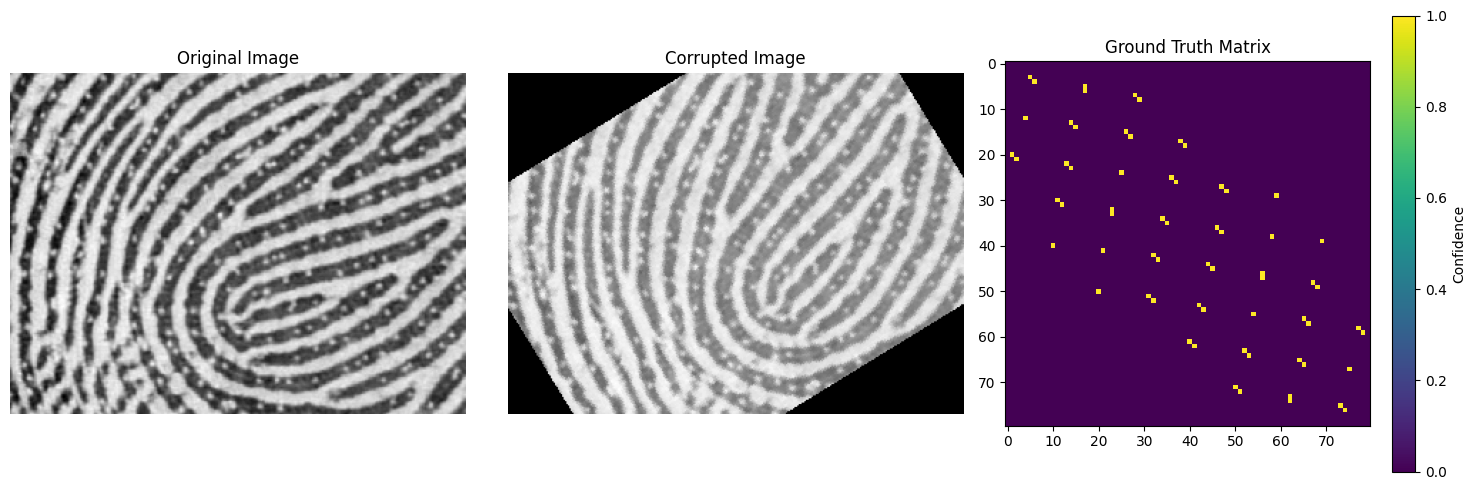

In [104]:
original_image_np = original_image.squeeze(0).numpy()  # [H, W]
corrupted_image_np = corrupted_image.squeeze(0).numpy()  # [H, W]

# Plot images and matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Corrupted Image")
plt.imshow(corrupted_image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Matrix")
plt.imshow(ground_truth, cmap='viridis')
plt.colorbar(label="Confidence")

plt.tight_layout()
plt.show()

In [106]:

vit_model.to(device)
feature_extractor.to(device)

# Set the model to training mode
vit_model.train()

# Initialize a single loop to test
total_train_loss = 0

image_path = 'L3SF-Model/original/1_1_1.png'  # Replace with your image path
original_images = load_and_preprocess_image(image_path)  # Shape: [1, H, W]

# Rotate the tensor image
corrupted_images, angle = random_rotate_tensor(original_image)

# Create the ground truth matrix
ground_truth_matrices = create_ground_truth_matrix(original_image.squeeze(0), angle)


# Move data to the device
original_images = original_images.to(device)
corrupted_images = corrupted_images.to(device)
ground_truth_matrices = ground_truth_matrices.to(device)

# If the input has 1 channel, repeat to match 3 input channels for ResNet
original_images = original_images.repeat(1, 3, 1, 1)
corrupted_images = corrupted_images.repeat(1, 3, 1, 1)

# Forward pass through feature extractor
F1 = feature_extractor(original_images)
F2 = feature_extractor(corrupted_images)

# Forward pass through ViT model
F1_prime, F2_prime = vit_model(F1, F2)

# Calculate correlation matrix and confidence matrix
correlation_matrix = calculate_correlation(F1_prime, F2_prime)
confidence_matrix = dual_softmax(correlation_matrix)

# Compute loss
loss = dense_registration_loss(confidence_matrix, ground_truth_matrices, device)

# Backpropagation and optimization
optimizer.zero_grad()
loss.backward()
optimizer.step()

# Save the loss for visualization
single_loss = loss.item()

print(f"Single Training Loop Loss: {single_loss:.4f}")

Single Training Loop Loss: 16.7945


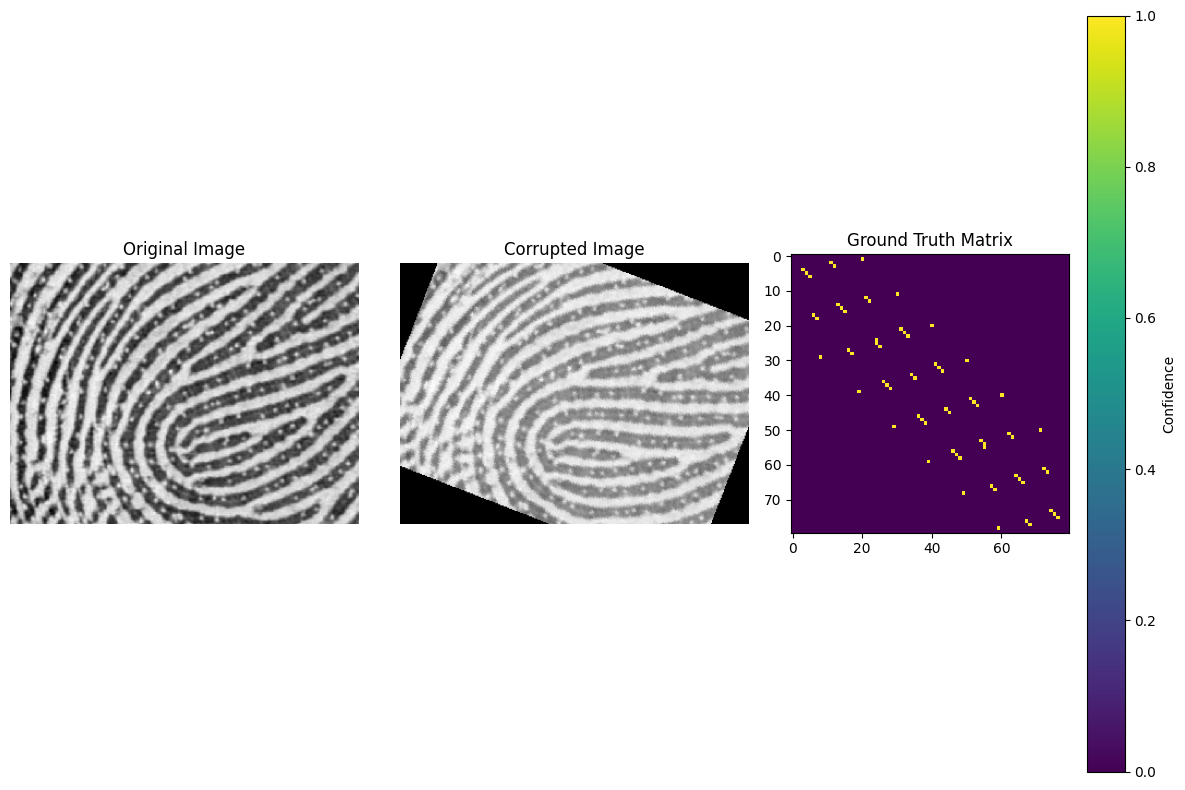

In [107]:

# Visualization of original, corrupted images, and ground truth matrix
original_image_to_display = original_images[0].cpu().permute(1, 2, 0).numpy()[:, :, 0]  # Grayscale version
corrupted_image_to_display = corrupted_images[0].cpu().permute(1, 2, 0).numpy()[:, :, 0]  # Grayscale version
ground_truth_to_display = ground_truth_matrices.cpu().numpy()

# Plot images and matrix
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_to_display, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Corrupted Image")
plt.imshow(corrupted_image_to_display, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Matrix")
plt.imshow(ground_truth_to_display, cmap='viridis')
plt.colorbar(label="Confidence")

plt.tight_layout()
plt.show()

ACTUAL TRAINING: 15 EPOCHS

In [108]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ViT(in_channels=512, embed_dim=256, patch_size=1, num_heads=4, num_layers=6, forward_dim=512).to(device)
feature_extractor = ResNet18FeatureExtractor().to(device)
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)
num_epochs = 15

Epoch 1/15:   0%|          | 0/1822 [00:00<?, ?batch/s]C:\Users\johnm\AppData\Local\Temp\ipykernel_23520\3916111641.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig

Epoch [1/15], Average Training Loss: 3.5968


Epoch 2/15: 100%|██████████| 1822/1822 [02:46<00:00, 10.92batch/s, loss=1.66] 


Epoch [2/15], Average Training Loss: 1.1912


Epoch 3/15: 100%|██████████| 1822/1822 [02:47<00:00, 10.88batch/s, loss=0.813]


Epoch [3/15], Average Training Loss: 0.8353


Epoch 4/15: 100%|██████████| 1822/1822 [02:48<00:00, 10.84batch/s, loss=0.472]


Epoch [4/15], Average Training Loss: 0.6981


Epoch 5/15: 100%|██████████| 1822/1822 [02:47<00:00, 10.90batch/s, loss=0.596]


Epoch [5/15], Average Training Loss: 0.6168


Epoch 6/15: 100%|██████████| 1822/1822 [02:44<00:00, 11.05batch/s, loss=0.492]


Epoch [6/15], Average Training Loss: 0.5523


Epoch 7/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.95batch/s, loss=0.637]


Epoch [7/15], Average Training Loss: 0.5128


Epoch 8/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.93batch/s, loss=0.508] 


Epoch [8/15], Average Training Loss: 0.4834


Epoch 9/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.93batch/s, loss=0.405]


Epoch [9/15], Average Training Loss: 0.4605


Epoch 10/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.93batch/s, loss=0.585] 


Epoch [10/15], Average Training Loss: 0.4382


Epoch 11/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.92batch/s, loss=0.442]


Epoch [11/15], Average Training Loss: 0.4229


Epoch 12/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.92batch/s, loss=0.377] 


Epoch [12/15], Average Training Loss: 0.4033


Epoch 13/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.95batch/s, loss=0.296]


Epoch [13/15], Average Training Loss: 0.3907


Epoch 14/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.98batch/s, loss=0.319] 


Epoch [14/15], Average Training Loss: 0.3778


Epoch 15/15: 100%|██████████| 1822/1822 [02:32<00:00, 11.92batch/s, loss=0.3]   


Epoch [15/15], Average Training Loss: 0.3636
Model training complete and saved!


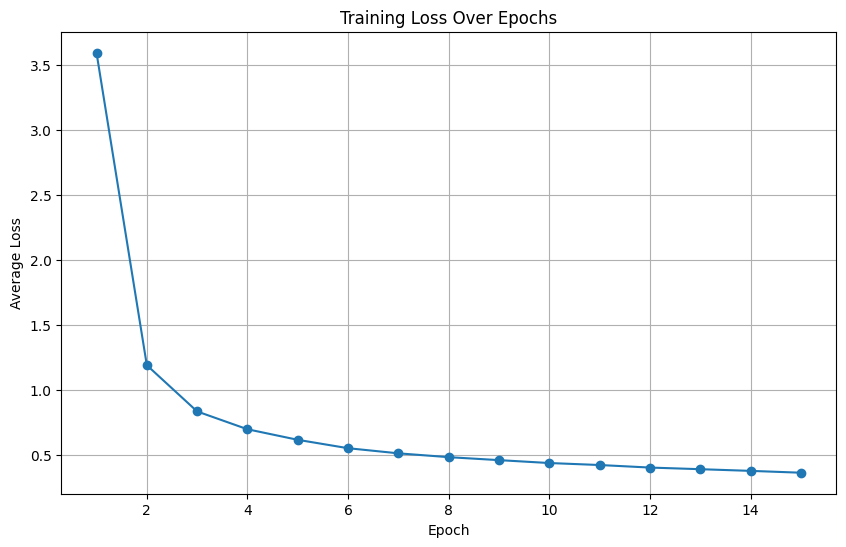

In [65]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize variables for tracking training loss
losses = []

# Main training loop
for epoch in range(num_epochs):
    vit_model.train()
    total_train_loss = 0
    
    # Initialize the progress bar for each epoch
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
        
        for original_images, corrupted_images, ground_truth_matrices in tepoch:
            # Move data to the device (GPU or CPU)
            original_images = original_images.to(device)
            corrupted_images = corrupted_images.to(device)
            ground_truth_matrices = ground_truth_matrices.to(device)
            
            original_images = original_images.repeat(1, 3, 1, 1)  # [batch_size, 3, 240, 320]
            corrupted_images = corrupted_images.repeat(1, 3, 1, 1)  # [batch_size, 3, 240, 320]

            # Step 1: Extract feature maps using ResNet-18
            F1 = feature_extractor(original_images)  # Feature map for original image
            F2 = feature_extractor(corrupted_images)  # Feature map for corrupted image

            # Step 2: Pass feature maps into ViT
            F1_prime, F2_prime = vit_model(F1, F2)

            # Step 3: Calculate correlation matrix and confidence matrix
            correlation_matrix = calculate_correlation(F1_prime, F2_prime)
            confidence_matrix = dual_softmax(correlation_matrix)

            # Step 4: Compute loss
            loss = dense_registration_loss(confidence_matrix, ground_truth_matrices, device)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss for monitoring
            total_train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(dataloader)
    losses.append(avg_train_loss)  # Track the average training loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}")

# Save the trained model after training is complete
torch.save(vit_model.state_dict(), "dense_registration_model.pth")
print("Model training complete and saved!")

# Visualization of training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()


In [109]:
image_path = 'L3SF-Model/original/1_1_2.png'  # Replace with your image path
original_images = load_and_preprocess_image(image_path)  # Shape: [1, H, W]

model_path = "dense_registration_model.pth"
vit_model.load_state_dict(torch.load(model_path))
vit_model.to(device)
# Rotate the tensor image
corrupted_images, angle = random_rotate_tensor(original_images)

# Create the ground truth matrix
ground_truth_matrices = create_ground_truth_matrix(original_images.squeeze(0), angle)


# Move data to the device
original_images = original_images.to(device)
corrupted_images = corrupted_images.to(device)
ground_truth_matrices = ground_truth_matrices.to(device)

# If the input has 1 channel, repeat to match 3 input channels for ResNet
original_images = original_images.repeat(1, 3, 1, 1)
corrupted_images = corrupted_images.repeat(1, 3, 1, 1)

# Forward pass through feature extractor
F1 = feature_extractor(original_images)
F2 = feature_extractor(corrupted_images)

# Forward pass through ViT model
F1_prime, F2_prime = vit_model(F1, F2)

# Calculate correlation matrix and confidence matrix
C = calculate_correlation(F1_prime, F2_prime)
P = dual_softmax(C)

matches = filter_matches(P[0], threshold)

print(matches)
print(angle)
print(F1.shape, F2.shape)
print(F1_prime.shape, F2_prime.shape)
print(C.shape)
print(P.shape)
print(ground_truth_matrices)

C:\Users\johnm\AppData\Local\Temp\ipykernel_23128\269116650.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(model_path))


tensor([[ 1, 20],
        [ 2, 11],
        [ 3, 12],
        [ 6,  4],
        [11, 30],
        [12, 21],
        [13, 22],
        [15, 14],
        [16, 15],
        [17,  6],
        [18,  7],
        [20, 40],
        [21, 41],
        [22, 32],
        [23, 33],
        [25, 24],
        [27, 16],
        [29,  8],
        [30, 50],
        [31, 51],
        [32, 42],
        [33, 43],
        [34, 34],
        [35, 35],
        [36, 26],
        [37, 27],
        [39, 18],
        [40, 61],
        [42, 52],
        [43, 53],
        [44, 44],
        [45, 45],
        [46, 36],
        [47, 37],
        [48, 28],
        [49, 29],
        [50, 71],
        [51, 62],
        [52, 63],
        [53, 64],
        [54, 55],
        [55, 56],
        [56, 46],
        [57, 47],
        [58, 38],
        [59, 39],
        [61, 72],
        [62, 73],
        [64, 65],
        [66, 57],
        [68, 49],
        [70, 70],
        [76, 67],
        [77, 58],
        [78, 59],
        [7

use one image for training and plot the visualize on the matrix. 

ploting the matches on to a 80x80 matrix and compare it with ground truth

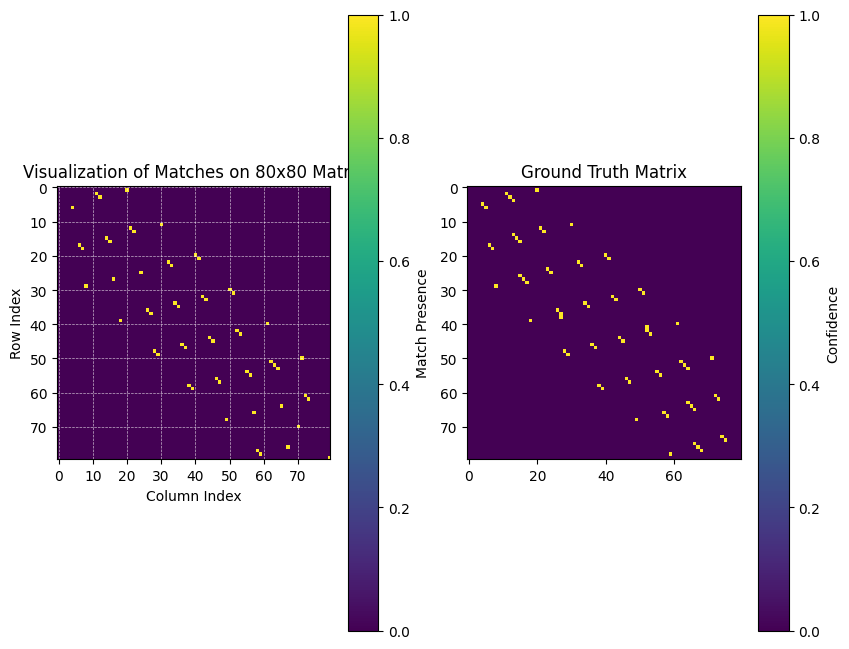

In [110]:
matrix_size = 80
output_matrix = np.zeros((matrix_size, matrix_size))

ground_truth_to_display = ground_truth_matrices.cpu().numpy()

for match in matches:
    x, y = match.tolist()
    output_matrix[x, y] = 1  # Mark the match point

# Plot the matrix
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.title("Visualization of Matches on 80x80 Matrix")
plt.imshow(output_matrix, cmap='viridis')
plt.colorbar(label="Match Presence")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.xticks(range(0, matrix_size, 10))
plt.yticks(range(0, matrix_size, 10))
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.7)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Matrix")
plt.imshow(ground_truth_to_display, cmap='viridis')
plt.colorbar(label="Confidence")

plt.show()

In [ ]:
# import os
# import torch
# from PIL import Image
# import numpy as np

# # Define source and destination directories
# source_root = "L3SF_V2/Pore/Fingerprint_Images"
# destination_root = "L3SF-Test"
# original_dest = os.path.join(destination_root, "original")
# corrupted_dest = os.path.join(destination_root, "corrupted")

# # Create destination directories if they don't exist
# os.makedirs(original_dest, exist_ok=True)
# os.makedirs(corrupted_dest, exist_ok=True)

# # Define mappings for consistent image types
# type_mapping = {
#     "left": "left_loop",
#     "plain": "plain_arch",
#     "right": "right_loop",
#     "tented": "tented_arch",
#     "whorl": "whorl"
# }

# # Cumulative image counter across folders
# image_counter = 1

# # Process and save original and rotated images in .pt format
# for i in range(1, 6):  # Loop through R1 to R5 folders
#     folder_name = f"R{i}"
#     source_folder = os.path.join(source_root, folder_name)
    
#     if os.path.exists(source_folder):
#         for filename in os.listdir(source_folder):
#             # Ensure file format is correct
#             if "_" in filename and filename.split("_")[0].isdigit():
#                 img_type_raw = filename.split("_")[1].split(".")[0]  # Raw type name (e.g., left, right)
                
#                 # Map to standardized type name
#                 img_type = type_mapping.get(img_type_raw, img_type_raw)
                
#                 # Define base name for original images
#                 img_index = ["left_loop", "plain_arch", "right_loop", "tented_arch", "whorl"].index(img_type) + 1
#                 base_name = f"{image_counter}_{img_index}"
                
#                 img_path = os.path.join(source_folder, filename)
#                 try:
#                     # Load and process original image
#                     img = Image.open(img_path).convert("L")  # Convert to grayscale
#                     original_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0)
                    
#                     # Save original image with .pt format
#                     original_save_path = os.path.join(original_dest, f"{base_name}.pt")
#                     torch.save(original_tensor, original_save_path)
                    
#                     # Generate one rotated version
#                     rotated_img, angle = random_rotate(img)
#                     rotated_tensor = torch.tensor(np.array(rotated_img), dtype=torch.float32).unsqueeze(0)
                    
#                     # Save rotated image with angle in filename
#                     corrupted_save_path = os.path.join(corrupted_dest, f"{base_name}_{int(angle)}.pt")
#                     torch.save(rotated_tensor, corrupted_save_path)
                    
#                     # Increment the cumulative image counter
#                     image_counter += 1
                    
#                 except Exception as e:
#                     print(f"Error processing {filename}: {e}")
#     else:
#         print(f"Folder {source_folder} does not exist.")

# print("Dataset setup complete.")




Dataset setup complete.


In [111]:
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import numpy as np

class TestDataset(Dataset):
    def __init__(self, data_root):
        self.original_dir = os.path.join(data_root, "original")
        self.corrupted_dir = os.path.join(data_root, "corrupted")
        
        # Prepare list of (original, corrupted, angle) triplets
        self.image_triplets = []

        # Regex to capture the initial number in the filename (e.g., `1` in `1_3` or `1_3_{angle}.pt`)
        original_pattern = re.compile(r"^(\d+)_\d+\.pt$")
        corrupted_pattern = re.compile(r"^(\d+)_\d+_(-?\d+)\.pt$")
        
        # Transform for resizing and ensuring single channel
        self.transform = Compose([
            Resize((240, 320)),  # Resize to 240x320
            ToTensor()           # Convert to tensor
        ])
        
        # Load all corrupted file paths in a dictionary by base number
        corrupted_files = {}
        for corrupted_img in os.listdir(self.corrupted_dir):
            match = corrupted_pattern.match(corrupted_img)
            if match:
                base_number, angle = match.groups()
                angle = int(angle)  # Convert angle to an integer
                if base_number not in corrupted_files:
                    corrupted_files[base_number] = []
                corrupted_files[base_number].append((os.path.join(self.corrupted_dir, corrupted_img), angle))
        
        # Match corrupted images based on the original filenames by initial number
        for original_img in os.listdir(self.original_dir):
            match = original_pattern.match(original_img)
            if match:
                base_number = match.group(1)
                original_path = os.path.join(self.original_dir, original_img)
                
                # If we find corrupted images with the same base number, create triplets
                if base_number in corrupted_files:
                    for corrupted_path, angle in corrupted_files[base_number]:
                        self.image_triplets.append((original_path, corrupted_path, angle))
                else:
                    print(f"No corrupted image found for {original_img}")
        
        print(f"Total image triplets found: {len(self.image_triplets)}")

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        original_path, corrupted_path, angle = self.image_triplets[idx]
        
        # Load preprocessed tensors
        original_tensor = torch.load(original_path)
        corrupted_tensor = torch.load(corrupted_path)

        # Convert tensors to NumPy arrays and then to PIL Images
        original_image = Image.fromarray((original_tensor.numpy() * 255).astype(np.uint8).squeeze(), mode="L")
        corrupted_image = Image.fromarray((corrupted_tensor.numpy() * 255).astype(np.uint8).squeeze(), mode="L")

        # Apply transformations to resize images to [1, 240, 320]
        original_image = self.transform(original_image)
        corrupted_image = self.transform(corrupted_image)

        # Generate the ground truth alignment matrix based on the rotation angle
        ground_truth_matrix = create_ground_truth_matrix(
            original_image.squeeze(0), angle, patch_dim_H=8, patch_dim_W=10
        )
        
        return original_image, corrupted_image, ground_truth_matrix


In [112]:
# Assuming similar structure as training dataset
test_data_root = "L3SF-Test"  # Directory for test data
test_dataset = TestDataset(data_root=test_data_root)  # Test dataset

# Check if dataset has any items
print(f"Total samples in the dataset: {len(test_dataset)}")

Total image triplets found: 740
Total samples in the dataset: 740


In [113]:
model_path = "dense_registration_model.pth"
vit_model.load_state_dict(torch.load(model_path))
vit_model.to(device)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)
original_images, corrupted_images, ground_truth_matrices = next(iter(test_loader))

print(f"Original images shape: {original_images.shape}")   # Expected: [batch_size, 1, 240, 320]
print(f"Corrupted images shape: {corrupted_images.shape}")  # Expected: [batch_size, 1, 240, 320]
print(f"Ground truth matrices shape: {ground_truth_matrices.shape}")  # Expected: [batch_size, 80, 80]
    

Original images shape: torch.Size([4, 1, 240, 320])
Corrupted images shape: torch.Size([4, 1, 240, 320])
Ground truth matrices shape: torch.Size([4, 80, 80])


C:\Users\johnm\AppData\Local\Temp\ipykernel_23128\425021651.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(model_path))
C:\Users\jo

C:\Users\johnm\AppData\Local\Temp\ipykernel_23128\1901309900.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_tensor = torch.load(original_path)
C:\Users\johnm\

Mean Squared Error (MSE): 0.0012
Intersection over Union (IoU): 0.8533


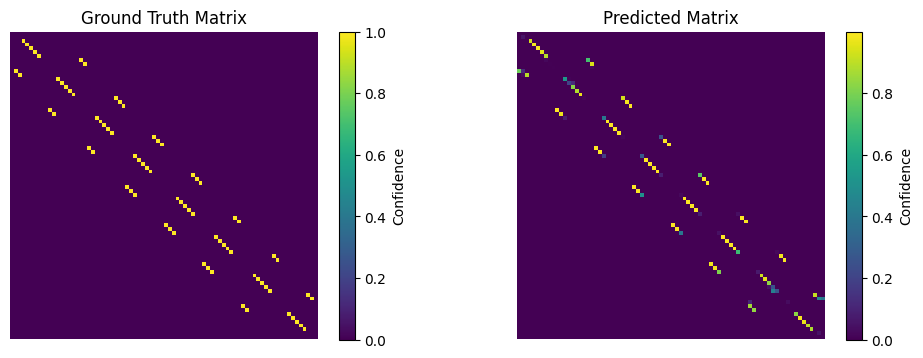

In [114]:
vit_model.eval()
    
for original_images, corrupted_images, ground_truth_matrices in test_loader:
    # Move data to the device (GPU or CPU)
    original_images = original_images.to(device)
    corrupted_images = corrupted_images.to(device)
    ground_truth_matrices = ground_truth_matrices.to(device)
    
    # Repeat channel for compatibility
    original_images = original_images.repeat(1, 3, 1, 1)
    corrupted_images = corrupted_images.repeat(1, 3, 1, 1)

    # Extract feature maps using the feature extractor
    F1 = feature_extractor(original_images)
    F2 = feature_extractor(corrupted_images)

    # Pass feature maps into the ViT model
    F1_prime, F2_prime = vit_model(F1, F2)

    # Generate the confidence matrix
    C = calculate_correlation(F1_prime, F2_prime)
    P = dual_softmax(C)
    
    # Reshape confidence matrix for comparison
    predicted_matrix = P.detach().cpu().numpy()[0]  # [batch_size, 80, 80]
    ground_truth_matrix = ground_truth_matrices.cpu().numpy()[0]
    
    # Compute evaluation metrics
    mse = F.mse_loss(torch.tensor(predicted_matrix), torch.tensor(ground_truth_matrix)).item()
    iou = (np.logical_and(predicted_matrix > 0.5, ground_truth_matrix == 1).sum() /
            np.logical_or(predicted_matrix > 0.5, ground_truth_matrix == 1).sum())

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Intersection over Union (IoU): {iou:.4f}")
    
    # Visualize matrices
    plt.figure(figsize=(12, 4))

    # Ground truth
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth Matrix")
    plt.imshow(ground_truth_matrix, cmap="viridis")
    plt.colorbar(label="Confidence")
    plt.axis("off")

    # Predicted matrix
    plt.subplot(1, 2, 2)
    plt.title("Predicted Matrix")
    plt.imshow(predicted_matrix, cmap="viridis")
    plt.colorbar(label="Confidence")
    plt.axis("off")

    plt.show()

    # Break after visualizing one batch
    break

Finger Alignment

C:\Users\johnm\AppData\Local\Temp\ipykernel_23128\2465534427.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(model_path))


rotated: torch.Size([1, 3, 240, 320])
Matix: (80, 80)
tensor([[ 0,  0],
        [ 3,  5],
        [ 4,  6],
        [ 5, 17],
        [ 6, 18],
        [ 7, 28],
        [ 8, 39],
        [ 9,  9],
        [12,  4],
        [13, 14],
        [14, 15],
        [15, 26],
        [16, 27],
        [17, 38],
        [20,  1],
        [21,  2],
        [22, 13],
        [24, 25],
        [25, 36],
        [26, 37],
        [27, 47],
        [28, 48],
        [29, 59],
        [30, 11],
        [31, 12],
        [32, 23],
        [34, 34],
        [35, 35],
        [36, 46],
        [38, 58],
        [39, 69],
        [40, 10],
        [41, 21],
        [43, 33],
        [44, 44],
        [45, 45],
        [47, 56],
        [48, 67],
        [49, 68],
        [50, 20],
        [51, 31],
        [52, 32],
        [53, 42],
        [55, 54],
        [56, 65],
        [57, 66],
        [59, 78],
        [62, 41],
        [63, 52],
        [64, 53],
        [65, 64],
        [67, 75],
        [6

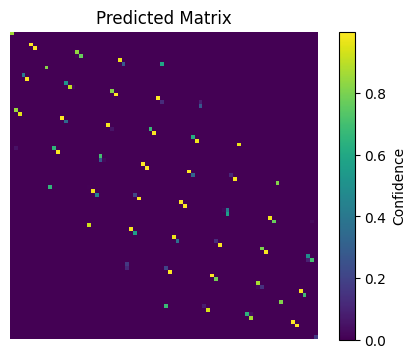

In [115]:
image_path = 'L3SF-Model/original/1_1_3.png'  # Replace with your image path
original_images = load_and_preprocess_image(image_path)  # Shape: [1, H, W]

vit_model_path = "dense_registration_model.pth"
vit_model.load_state_dict(torch.load(model_path))
vit_model.to(device)
# Rotate the tensor image
corrupted_images, angle = random_rotate_tensor(original_images)

# Create the ground truth matrix
ground_truth_matrices = create_ground_truth_matrix(original_images.squeeze(0), angle)


# Move data to the device
original_images = original_images.to(device)
corrupted_images = corrupted_images.to(device)
ground_truth_matrices = ground_truth_matrices.to(device)

# If the input has 1 channel, repeat to match 3 input channels for ResNet
original_images = original_images.repeat(1, 3, 1, 1)
corrupted_images = corrupted_images.repeat(1, 3, 1, 1)

# Forward pass through feature extractor
F1 = feature_extractor(original_images)
F2 = feature_extractor(corrupted_images)

# Forward pass through ViT model
F1_prime, F2_prime = vit_model(F1, F2)

# Calculate correlation matrix and confidence matrix
C = calculate_correlation(F1_prime, F2_prime)
P = dual_softmax(C)

matches = filter_matches(P[0], threshold)

ground_truth_matrix = P.detach().cpu().numpy()[0]  # [batch_size, 80, 80]

print(f"rotated: {corrupted_images.shape}")
print(f"Matix: {ground_truth_matrix.shape}")
print(matches)
print(angle)
plt.figure(figsize=(12, 4))

# Predicted matrix
plt.subplot(1, 2, 1)
plt.title("Predicted Matrix")
plt.imshow(ground_truth_matrix, cmap="viridis")
plt.colorbar(label="Confidence")
plt.axis("off")

plt.show()


In [116]:
import numpy as np

def calculate_angle(matches):
    # Parameters
    image_width = 320  
    image_height = 240  
    num_patches_x = 10  
    num_patches_y = 8   

    # Generate patch centers for the grid
    x_centers = np.linspace(image_width / (2 * num_patches_x), image_width - image_width / (2 * num_patches_x), num_patches_x)
    y_centers = np.linspace(image_height / (2 * num_patches_y), image_height - image_height / (2 * num_patches_y), num_patches_y)
    patch_centers = np.array([(x, y) for y in y_centers for x in x_centers])

    # Keypoint pairs tensor
    kp_pairs_tensor = matches  # Replace 'matches' with your tensor of keypoint pairs

    # Convert PyTorch tensor to NumPy array
    kp_pairs = kp_pairs_tensor.cpu().numpy()

    # Extract corresponding patch centers
    original_coords = patch_centers[kp_pairs[:, 0] - 1]  # Original image patch centers
    rotated_coords = patch_centers[kp_pairs[:, 1] - 1]   # Rotated image patch centers

    # Calculate the rotation angle using vectors from the image center
    image_center = np.array([image_width / 2, image_height / 2])
    vectors_original = original_coords - image_center
    vectors_rotated = rotated_coords - image_center

    # Compute angles of vectors relative to the center
    angles_original = np.arctan2(vectors_original[:, 1], vectors_original[:, 0])
    angles_rotated = np.arctan2(vectors_rotated[:, 1], vectors_rotated[:, 0])

    # Calculate angular difference
    angle_differences = angles_rotated - angles_original

    # Normalize the angles to [-π, π]
    angle_differences = (angle_differences + np.pi) % (2 * np.pi) - np.pi

    # Compute vector magnitudes for weighting
    magnitudes = np.linalg.norm(vectors_original, axis=1)

    # Combine angle differences and magnitudes into one array for consistent filtering
    data = np.vstack((angle_differences, magnitudes)).T

    # Remove outliers using IQR iteratively
    for _ in range(2):  # Two iterations of IQR-based refinement
        q1 = np.percentile(data[:, 0], 25)
        q3 = np.percentile(data[:, 0], 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = data[(data[:, 0] >= lower_bound) & (data[:, 0] <= upper_bound)]

    # Extract filtered differences and magnitudes
    filtered_differences = data[:, 0]
    filtered_magnitudes = data[:, 1]

    # Normalize magnitudes to avoid domination by larger vectors
    normalized_magnitudes = filtered_magnitudes / np.sum(filtered_magnitudes)

    # Weight angular differences by normalized magnitudes
    weighted_mean_difference = np.sum(filtered_differences * normalized_magnitudes) / np.sum(normalized_magnitudes)

    # Convert the weighted mean difference to degrees
    rotation_angle = np.degrees(weighted_mean_difference)

    return rotation_angle


rotation_angle = calculate_angle(matches)
print(rotation_angle)

27.94861081336931


In [117]:
def specific_rotate_tensor(image_tensor, angle):
    image_tensor = image_tensor.squeeze(0)
    # Convert tensor back to PIL for rotation
    image_pil = transforms.ToPILImage()(image_tensor)
    rotated_pil = image_pil.rotate(angle)
    # Convert back to tensor
    rotated_tensor = transforms.ToTensor()(rotated_pil)
    return rotated_tensor

torch.Size([1, 3, 240, 320])
torch.Size([3, 240, 320])
torch.Size([1, 3, 240, 320])


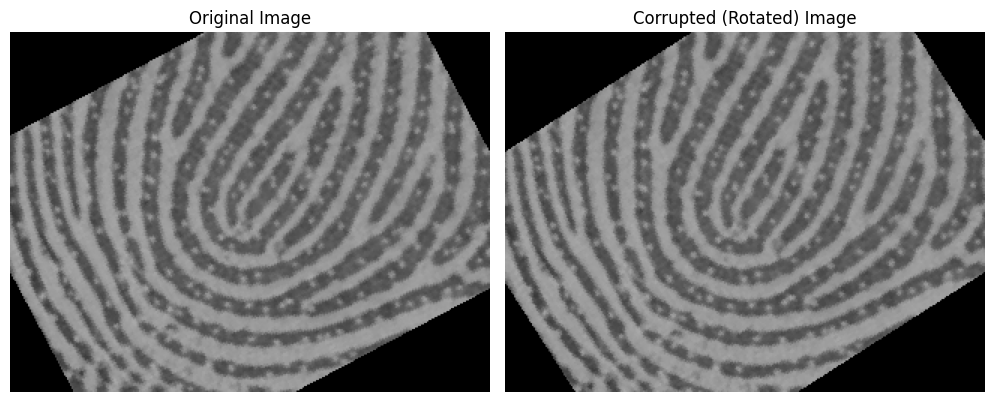

In [118]:
import torchvision.transforms.functional as F

print(original_images.shape)
rotated_image = specific_rotate_tensor(original_images, rotation_angle)

print(rotated_image.shape)
print(corrupted_images.shape)

original_image_np = rotated_image.permute(1, 2, 0).cpu().numpy() 
corrupted_image_np = corrupted_images.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C]

# Plot the images for visualization
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

# Corrupted (Rotated) Image
plt.subplot(1, 3, 2)
plt.title("Corrupted (Rotated) Image")
plt.imshow(corrupted_image_np)
plt.axis('off')

plt.tight_layout()
plt.show()

Make a second ViT. Get Descriptors from Images then use Euclidean distance for matching.

Triplet Dataset

In [119]:
import torchvision
import os
import pandas as pd
import random
from torchvision.io import read_image
from torch.utils.data import Dataset


class SyntheticDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mode='train'):
        self.img_labels = pd.read_csv(annotations_file, header=None, names=["image_name", "identity"])
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode

        # Organize the data by identity
        self.identity_dict = self._group_by_identity()
        self.identities = list(self.identity_dict.keys())  # Unique identities

    def _group_by_identity(self):
        """Groups images by identity for easier access."""
        identity_dict = {}
        for _, row in self.img_labels.iterrows():
            identity = row['identity']  # Column C2: Identity
            if identity not in identity_dict:
                identity_dict[identity] = []
            identity_dict[identity].append(row['image_name'])  # Column C1: Image names
        return identity_dict

    def __len__(self):
        return len(self.identities)  # Number of unique identities

    def __getitem__(self, idx):
        if self.mode == "train":
            # Select an identity for anchor and positive images
            anchor_identity = self.identities[idx]
            anchor_img, positive_img = random.sample(self.identity_dict[anchor_identity], 2)

            # Select a different identity for the negative image
            negative_identity = random.choice([id_ for id_ in self.identities if id_ != anchor_identity])
            negative_img = random.choice(self.identity_dict[negative_identity])

            # Load the images
            anchor = self._load_image(anchor_img)
            positive = self._load_image(positive_img)
            negative = self._load_image(negative_img)

            return anchor, positive, negative
        else:
            image_name = self.img_labels.iloc[idx]['image_name']
            identity = self.img_labels.iloc[idx]['identity']
            img_path = os.path.join(self.img_dir, image_name)
            image = read_image(img_path, mode=torchvision.io.ImageReadMode.GRAY).float()
            if self.transform:
                image = self.transform(image)
            return image, identity

            # identity = self.identities[idx]
            # image = self._load_image(identity)
            #
            # return image, identity

    def _load_image(self, image_name):
        """Loads and transforms an image."""
        img_path = os.path.join(self.img_dir, image_name)
        image = read_image(img_path, mode=torchvision.io.ImageReadMode.GRAY).float() /255.0
        if self.transform:
            image = self.transform(image)
        return image
    


batch_size = 16  
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5,), (0.5,))  # Normalize based on grayscale mean/std
    ])

train_dataset = SyntheticDataset(
    'L3SF_V2/L3-SF/r1_labels.csv',
    'L3SF_V2/L3-SF/R1',
    transform=transform,
    mode="train"
)


train_dataset2 = SyntheticDataset(
    'L3SF_V2/L3-SF/r2_labels.csv',
    'L3SF_V2/L3-SF/R2',
    transform=transform,
    mode="train"
)





In [120]:
from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset([train_dataset, train_dataset2])

print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

296


In [121]:
from torchvision.models import vit_b_16

class FingerprintDescriptorViT(nn.Module):
    def __init__(self, embedding_dim=256, pretrained=True):
        super(FingerprintDescriptorViT, self).__init__()
        # Load pretrained ViT
        self.vit = vit_b_16(pretrained=pretrained)
        self.embedding_dim = embedding_dim

        # Add a description token with trainable embeddings
        self.description_token = nn.Parameter(torch.zeros(1, 1, self.vit.hidden_dim))
        nn.init.normal_(self.description_token, std=0.02)

        # Remove classification head
        self.vit.heads = nn.Identity()

    def forward(self, x: torch.Tensor):
        # Process input to patches
        batch_size = x.size(0)
        x = self.vit._process_input(x)  # (batch_size, num_patches, hidden_dim)

        description_token = self.description_token.expand(batch_size, -1, -1)  # (batch_size, 1, hidden_dim)

        # Concatenate tokens with patches
        x = torch.cat([description_token, x], dim=1)  # (batch_size, num_patches+2, hidden_dim)

        # Pass through the transformer encoder
        x = self.vit.encoder(x)  # (batch_size, num_patches+2, hidden_dim)

        # Extract descriptor from the description token
        x = x[:, 0]  # (batch_size, hidden_dim)
        
        x - self.vit.heads(x)

        return x


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.nn.functional.pairwise_distance(anchor, positive, p=2)
        neg_dist = torch.nn.functional.pairwise_distance(anchor, negative, p=2)

        loss = torch.mean(torch.relu(pos_dist - neg_dist + self.margin))
        return loss   

In [122]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device setup
device = torch.device("cuda:1" if torch.cuda.device_count() > 1 else "cpu")

# Model, criterion, and optimizer
model = FingerprintDescriptorViT().to(device)
criterion = TripletLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]: 100%|██████████| 19/19 [07:06<00:00, 22.44s/it, Batch Loss=0.13]  


Epoch [1/10], Average Loss: 0.1094


Epoch [2/10]: 100%|██████████| 19/19 [06:53<00:00, 21.77s/it, Batch Loss=0.0397] 


Epoch [2/10], Average Loss: 0.1264


Epoch [3/10]: 100%|██████████| 19/19 [06:51<00:00, 21.64s/it, Batch Loss=0.00853]


Epoch [3/10], Average Loss: 0.0673


Epoch [4/10]: 100%|██████████| 19/19 [06:50<00:00, 21.61s/it, Batch Loss=0]     


Epoch [4/10], Average Loss: 0.0674


Epoch [5/10]: 100%|██████████| 19/19 [06:50<00:00, 21.63s/it, Batch Loss=0]     


Epoch [5/10], Average Loss: 0.0290


Epoch [6/10]: 100%|██████████| 19/19 [06:50<00:00, 21.59s/it, Batch Loss=0]     


Epoch [6/10], Average Loss: 0.0327


Epoch [7/10]: 100%|██████████| 19/19 [06:48<00:00, 21.48s/it, Batch Loss=0]     


Epoch [7/10], Average Loss: 0.0325


Epoch [8/10]: 100%|██████████| 19/19 [06:48<00:00, 21.49s/it, Batch Loss=0]     


Epoch [8/10], Average Loss: 0.0310


Epoch [9/10]: 100%|██████████| 19/19 [06:50<00:00, 21.60s/it, Batch Loss=0]      


Epoch [9/10], Average Loss: 0.0650


Epoch [10/10]: 100%|██████████| 19/19 [06:51<00:00, 21.67s/it, Batch Loss=0.0701]


Epoch [10/10], Average Loss: 0.0233


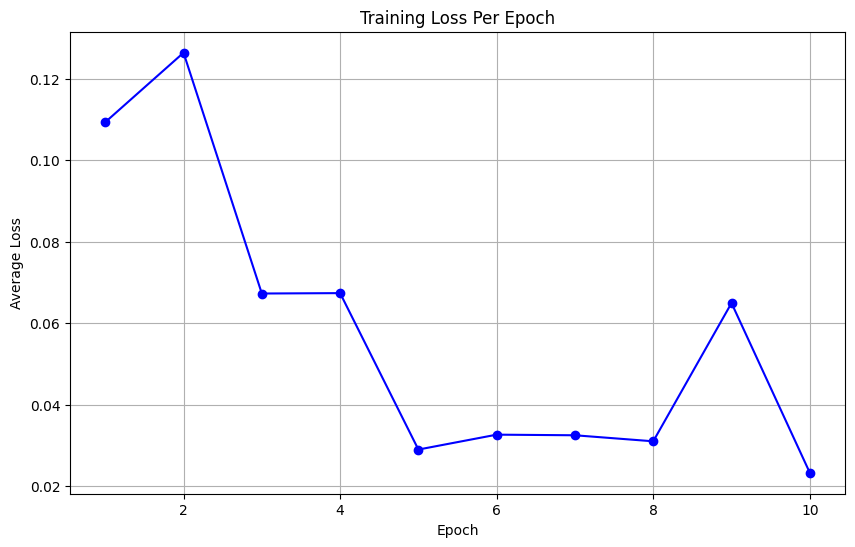

In [ ]:
# Training loop setup
num_epochs = 10
loss_history = []  # To store total loss per epoch

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

    for anchor, positive, negative in progress_bar:
        # Move triplets to the device
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Compute triplet loss
        loss = criterion(anchor_emb, positive_emb, negative_emb)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss and progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Visualize loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-', color='b')
plt.title("Training Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()


In [45]:
torch.save(model.state_dict(), "description_model.pth")
print("Model training complete and saved!")

Model training complete and saved!


In [123]:
batch_size = 1
dataset = SyntheticDataset(
    'L3SF_V2/L3-SF/r3_labels.csv',
    'L3SF_V2/L3-SF/R3',
    transform=transform,
    mode="train"
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [124]:
model_path = "description_model.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)


for anchor, positive, negative in loader:
    # Move triplets to the device
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)
    print(anchor.shape)
    print(positive.shape)
    print(negative.shape)
    # Forward pass
    anchor_emb = model(anchor)
    positive_emb = model(positive)
    negative_emb = model(negative)
    break



print(anchor_emb.shape)
print(positive_emb.shape)
print(negative_emb.shape)


C:\Users\johnm\AppData\Local\Temp\ipykernel_23128\3623042897.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])


In [125]:
euclidean_distance = torch.norm(anchor_emb - positive_emb, dim=1).item()  # Shape: [batch_size]
euclidean_distance2 = torch.norm(anchor_emb - negative_emb, dim=1).item()
print(f"Positive Euclidean Distance: {euclidean_distance}")
print(f"Negative Euclidean Distance: {euclidean_distance2}")

Positive Euclidean Distance: 2.21248459815979
Negative Euclidean Distance: 11.951350212097168


In [197]:
def identity(descriptor1: torch.Tensor, descriptor2: torch.Tensor, threshold: float = 5.0):
    euclidean_distance = torch.norm(descriptor1 - descriptor2, dim=1).item()
    
    identity = euclidean_distance <= threshold
    
    return euclidean_distance, identity

In [127]:
distance1, identity1 = identity(anchor_emb, positive_emb)
distance2, identity2 = identity(anchor_emb, negative_emb)

print(f"Euclidean Distance: {distance1:.2f}")
print(f"Same Identity: {'Yes' if identity1 else 'No'}")

print(f"Euclidean Distance: {distance2:.2f}")
print(f"Same Identity: {'Yes' if identity2 else 'No'}")

Euclidean Distance: 2.21
Same Identity: Yes
Euclidean Distance: 11.95
Same Identity: No


Final Pipeline

In [82]:
device = torch.device("cuda:1" if torch.cuda.device_count() > 1 else "cpu")
vit_model = ViT(in_channels=512, embed_dim=256, patch_size=1, num_heads=4, num_layers=6, forward_dim=512).to(device)
des_model = FingerprintDescriptorViT().to(device)
feature_extractor = ResNet18FeatureExtractor().to(device)

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMA

In [129]:
des_model_path = "description_model.pth"
des_model.load_state_dict(torch.load(des_model_path, weights_only=True))
des_model.to(device)

vit_model_path = "dense_registration_model.pth"
vit_model.load_state_dict(torch.load(vit_model_path, weights_only=True))
vit_model.to(device)

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Linear(in_features=512, out_features=256, bias=True)
  )
  (pos_embedding): PositionalEmbedding()
  (transformer_layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiHeadSelfAttention(
        (query): Linear(in_features=256, out_features=256, bias=True)
        (key): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (out): Linear(in_features=256, out_features=256, bias=True)
      )
      (cross_attn): CrossAttention(
        (query): Linear(in_features=256, out_features=256, bias=True)
        (key): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (out): Linear(in_features=256, out_features=256, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        

In [234]:
image_path1 = 'L3SF-Model/original/1_1_2.png'

image_path2 = 'L3SF-Model/original/146_2_2.png'  

# image_path2 = 'L3SF-Model/original/1_1_5.png'  

image1 = load_and_preprocess_image(image_path1)  # Shape: [1, H, W]
image2 = load_and_preprocess_image(image_path2)

image2, angle = random_rotate_tensor(image2)

feature_extractor.to(device)

image1 = image1.to(device)
image2 = image2.to(device)

# If the input has 1 channel, repeat to match 3 input channels for ResNet
image1 = image1.repeat(1, 3, 1, 1)
image2 = image2.repeat(1, 3, 1, 1)

# Forward pass through feature extractor
F1 = feature_extractor(image1)
F2 = feature_extractor(image2)

# Forward pass through ViT model
F1_prime, F2_prime = vit_model(F1, F2)

# Calculate correlation matrix and confidence matrix
C = calculate_correlation(F1_prime, F2_prime)
P = dual_softmax(C)

matches = filter_matches(P[0], threshold)

rotation_angle = calculate_angle(matches)

# print(rotation_angle)
# print(image1.shape)
# print(image2.shape)
# print(angle)
# print(matches)

aligned_image1 = specific_rotate_tensor(image1, rotation_angle)

# print(aligned_image1.shape)
# print(image2.shape)

transform1 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.Lambda(lambda x: x.unsqueeze(0))  # Add batch dimension to make it [1, 3, 224, 224]
])

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
])

aligned_image1 = transform1(aligned_image1)
image2 = transform2(image2)

# print(aligned_image1.shape)
# print(image2.shape)

des1 = des_model(aligned_image1)
des2 = des_model(image2)

print(des1.shape)
print(des2.shape)

distance_des, identity_des = identity(des1, des2)

print(f"Euclidean Distance: {distance_des:.2f}")
print(f"Same Identity: {'Yes' if identity_des else 'No'}")
print(angle)

torch.Size([1, 768])
torch.Size([1, 768])
Euclidean Distance: 6.81
Same Identity: No
7.67343236655806


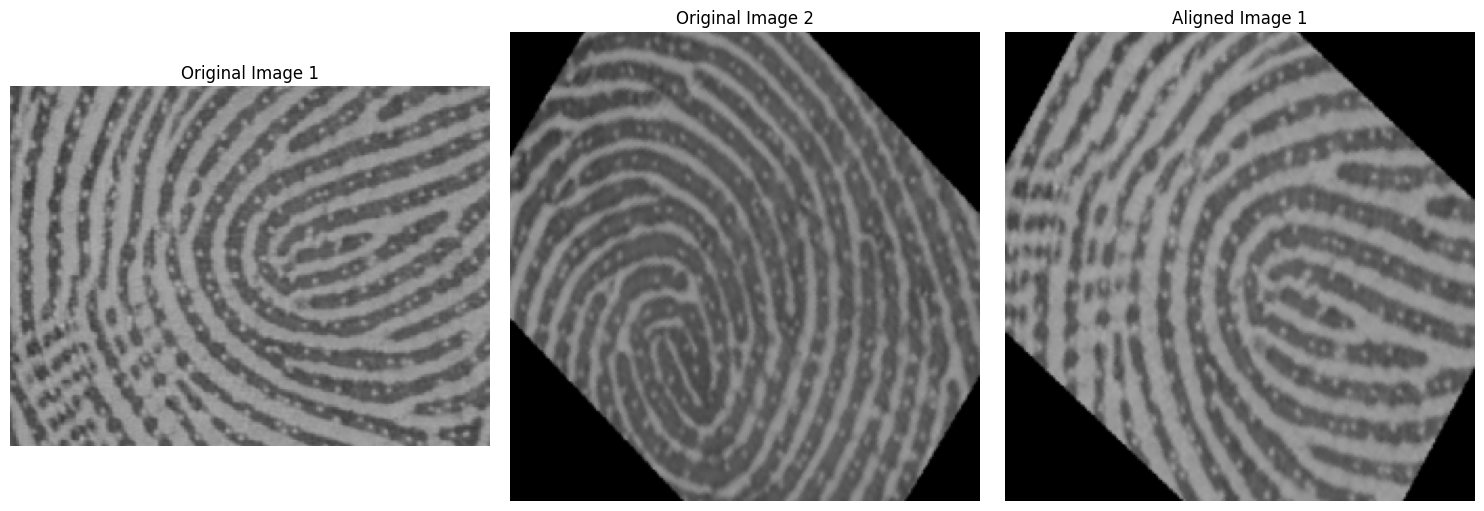

In [229]:
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays for visualization
def tensor_to_image(tensor):
    """Converts a PyTorch tensor to a NumPy image for visualization."""
    image = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    return image

# Convert images to NumPy arrays
image1_np = tensor_to_image(image1)
image2_np = tensor_to_image(image2)
aligned_image1_np = tensor_to_image(aligned_image1)

# Plot the images
plt.figure(figsize=(15, 5))

# Original image 1
plt.subplot(1, 3, 1)
plt.title("Original Image 1")
plt.imshow(image1_np, cmap='gray')
plt.axis("off")

# Original image 2
plt.subplot(1, 3, 2)
plt.title("Original Image 2")
plt.imshow(image2_np, cmap='gray')
plt.axis("off")

# Aligned image 1
plt.subplot(1, 3, 3)
plt.title("Aligned Image 1")
plt.imshow(aligned_image1_np, cmap='gray')
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()


In [232]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5,), (0.5,))  # Normalize based on grayscale mean/std
    ])

# Initialize dataset and DataLoader
d_dataset = SyntheticDataset(
    annotations_file='L3SF_V2/L3-SF/r5_labels.csv',
    img_dir='L3SF_V2/L3-SF/R5',
    transform=transform,
    mode="train"
)

dataloader_d = DataLoader(d_dataset, batch_size=1, shuffle=True)

print(len(d_dataset))
# Lists to store distances
positive_distances = []
negative_distances = []

# Run through the dataset
for anchor, positive, negative in dataloader_d:
    # Move images to device
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    # Forward pass through ViT
    anchor_desc = des_model(anchor)
    positive_desc = des_model(positive)
    negative_desc = des_model(negative)

    # Calculate Euclidean distances
    positive_distance = torch.norm(anchor_desc - positive_desc, p=2).item()
    negative_distance = torch.norm(anchor_desc - negative_desc, p=2).item()

    # Append to respective lists
    positive_distances.append(positive_distance)
    negative_distances.append(negative_distance)


print(len(positive_distances))
print(len(negative_distances))

148
148
148


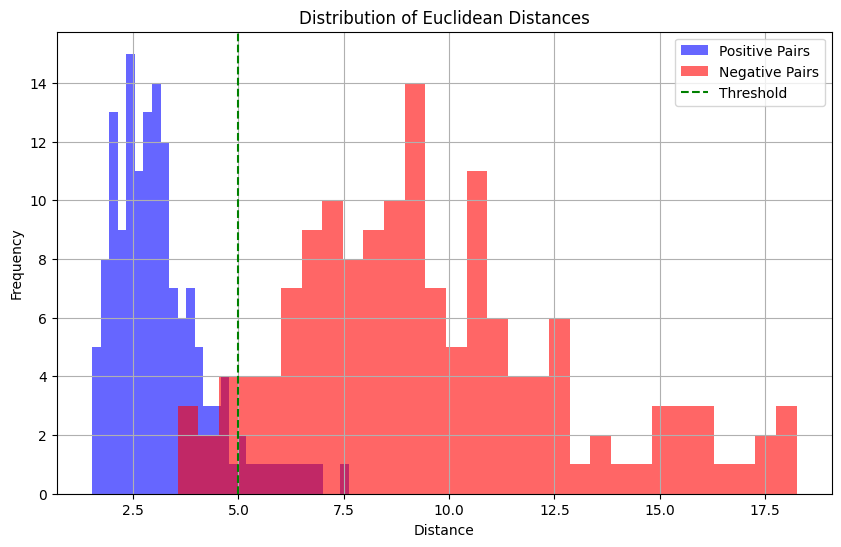

In [233]:
# Visualization
plt.figure(figsize=(10, 6))

# Plot positive distances
plt.hist(positive_distances, bins=30, alpha=0.6, label='Positive Pairs', color='blue')

# Plot negative distances
plt.hist(negative_distances, bins=30, alpha=0.6, label='Negative Pairs', color='red')

plt.axvline(x=5.0, color='green', linestyle='--', label='Threshold')
plt.title('Distribution of Euclidean Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

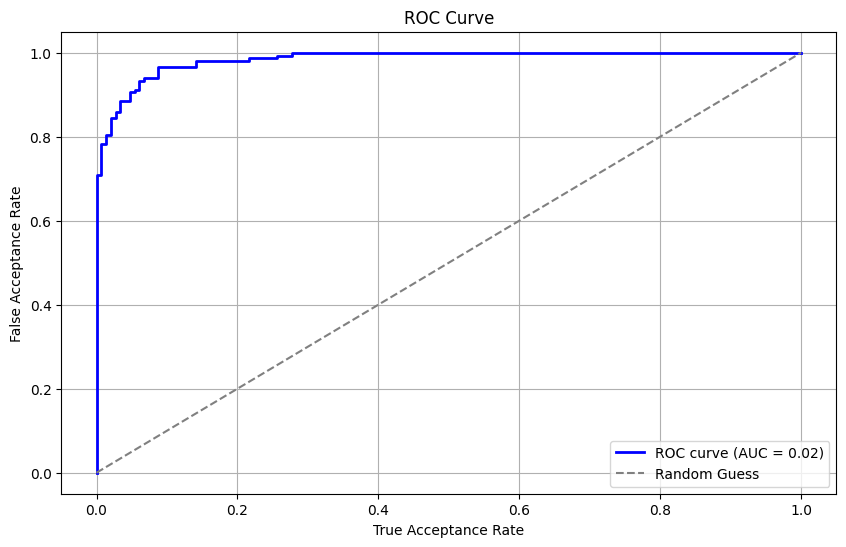

In [238]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Combine positive and negative distances
distances = np.array(positive_distances + negative_distances)
labels = np.array([1] * len(positive_distances) + [0] * len(negative_distances))  # 1 for positive, 0 for negative

# Compute FPR, TPR, and thresholds
far, tar, thresholds = roc_curve(labels, distances)

# Compute Area Under the Curve (AUC)
roc_auc = auc(far, tar)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(tar, far, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('True Acceptance Rate')
plt.ylabel('False Acceptance Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


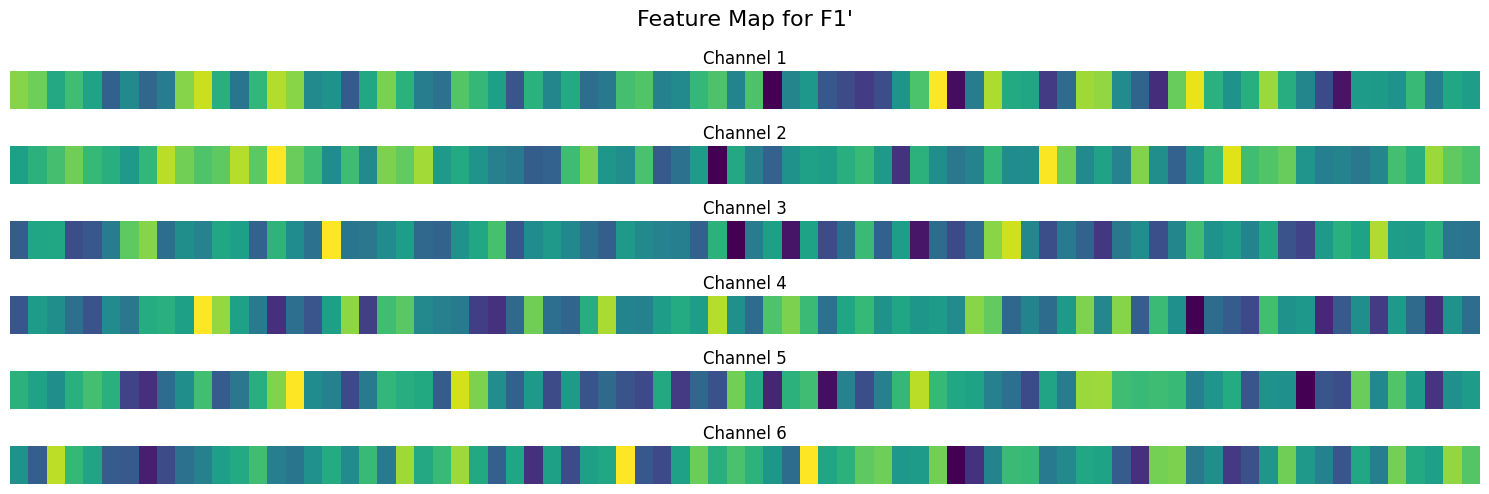

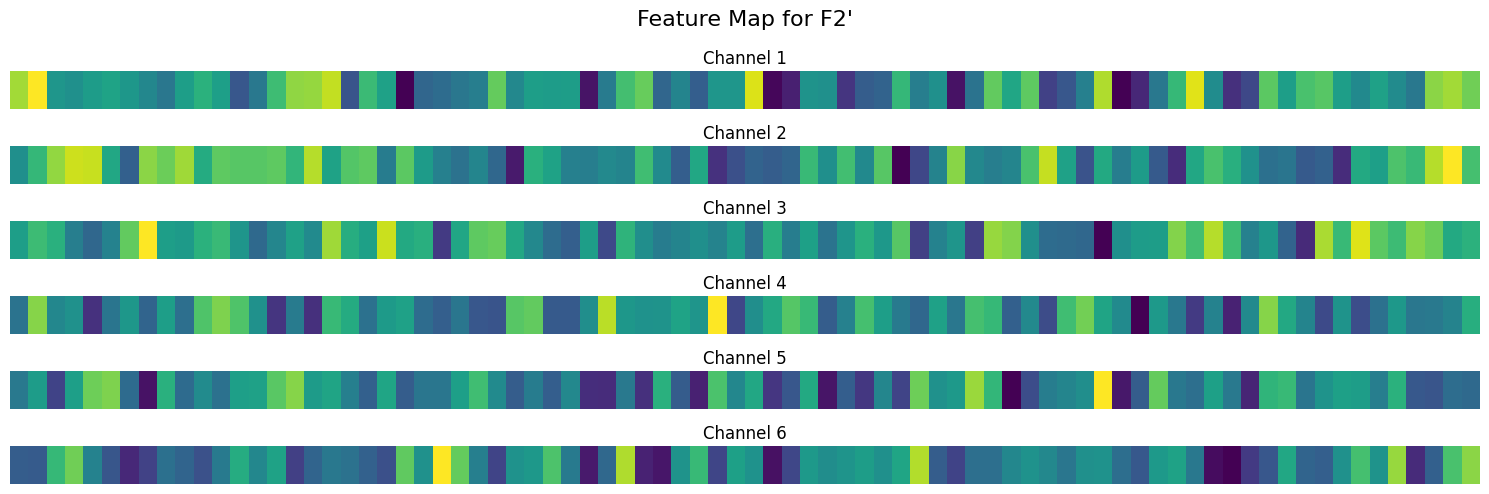

In [240]:
import matplotlib.pyplot as plt
import torch

def visualize_feature_maps(feature_map, num_channels=6, title="Feature Map Visualization"):
    """
    Visualizes the feature maps as a sequence when they cannot form a grid.
    Args:
        feature_map: The feature map tensor of shape [batch_size, num_patches, embed_dim].
        num_channels: Number of channels/embeddings to visualize.
        title: Title for the visualization.
    """
    # Ensure the feature map is detached and moved to CPU
    feature_map = feature_map.detach().cpu().numpy()
    
    # Select the first sample from the batch
    feature_map = feature_map[0]  # Shape: [num_patches, embed_dim]
    
    # Check the number of patches and embedding dimension
    num_patches = feature_map.shape[0]
    embed_dim = feature_map.shape[1]

    # Select the first `num_channels` channels to visualize
    feature_map = feature_map[:, :num_channels]  # Shape: [num_patches, num_channels]
    
    # Transpose for visualization: [num_patches, num_channels] -> [num_channels, num_patches]
    feature_map = feature_map.T
    
    # Plot each channel as a heatmap
    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 5), squeeze=False)
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_channels):
        axs[i, 0].imshow(feature_map[i:i+1], cmap="viridis", aspect="auto")
        axs[i, 0].axis("off")
        axs[i, 0].set_title(f"Channel {i + 1}")

    plt.tight_layout()
    plt.show()

# Example: Visualize the output from the ViT model
F1_prime, F2_prime = vit_model(F1, F2)

# Visualize the feature map for F1'
visualize_feature_maps(F1_prime, num_channels=6, title="Feature Map for F1'")
# Visualize the feature map for F2'
visualize_feature_maps(F2_prime, num_channels=6, title="Feature Map for F2'")


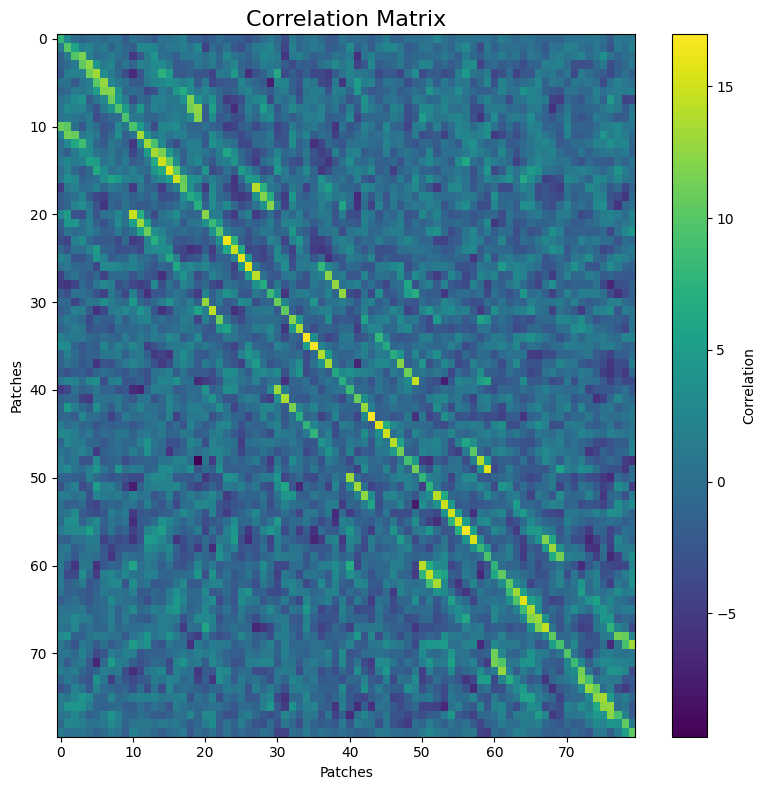

In [241]:
def visualize_correlation_matrix(correlation_matrix, title="Correlation Matrix"):
    """
    Visualizes the correlation matrix as a heatmap.
    Args:
        correlation_matrix: The correlation matrix tensor of shape [batch_size, num_patches, num_patches].
        title: Title for the heatmap.
    """
    # Ensure the correlation matrix is detached and moved to CPU
    correlation_matrix = correlation_matrix.detach().cpu().numpy()
    
    # Select the first sample from the batch
    correlation_matrix = correlation_matrix[0]  # Shape: [num_patches, num_patches]
    
    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    plt.title(title, fontsize=16)
    plt.imshow(correlation_matrix, cmap="viridis", aspect="auto")
    plt.colorbar(label="Correlation")
    plt.xlabel("Patches")
    plt.ylabel("Patches")
    plt.tight_layout()
    plt.show()

# Example: Visualize the correlation matrix
C = calculate_correlation(F1_prime, F2_prime)  # Correlation matrix
visualize_correlation_matrix(C, title="Correlation Matrix")

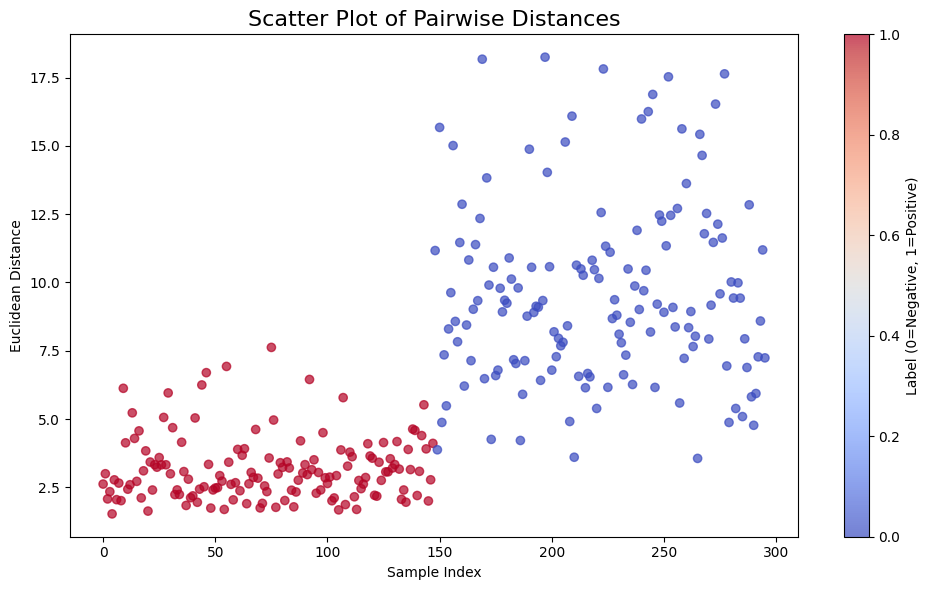

In [243]:
def visualize_distance_scatter(distances, labels, title="Distance Scatter Plot"):
    """
    Visualizes distances as a scatter plot.
    Args:
        distances: A list or array of distances.
        labels: Corresponding labels (0 for negatives, 1 for positives).
        title: Title for the scatter plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(distances)), distances, c=labels, cmap="coolwarm", alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel("Sample Index")
    plt.ylabel("Euclidean Distance")
    plt.colorbar(label="Label (0=Negative, 1=Positive)")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_distance_scatter(distances, labels, title="Scatter Plot of Pairwise Distances")


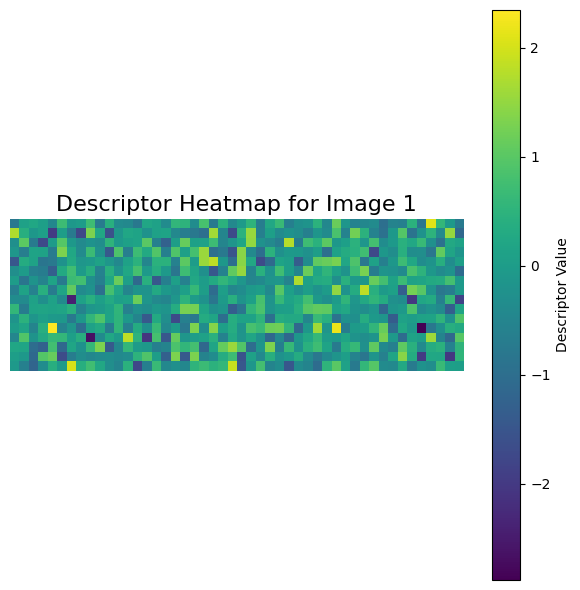

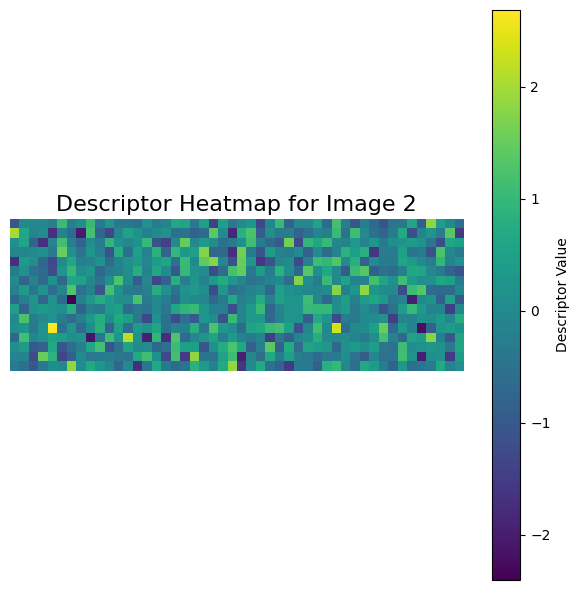

In [244]:
def visualize_descriptor_heatmap(descriptor, title="Descriptor Heatmap"):
    """
    Visualizes a descriptor vector as a heatmap.
    Args:
        descriptor: A 1D tensor or numpy array of shape [embedding_dim].
        title: Title for the heatmap.
    """
    descriptor_2d = descriptor.view(16, -1).cpu().detach().numpy()  # Reshape to 16x16 for visualization
    plt.figure(figsize=(6, 6))
    plt.title(title, fontsize=16)
    plt.imshow(descriptor_2d, cmap="viridis")
    plt.colorbar(label="Descriptor Value")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize descriptors
visualize_descriptor_heatmap(des1.squeeze(), title="Descriptor Heatmap for Image 1")
visualize_descriptor_heatmap(des2.squeeze(), title="Descriptor Heatmap for Image 2")


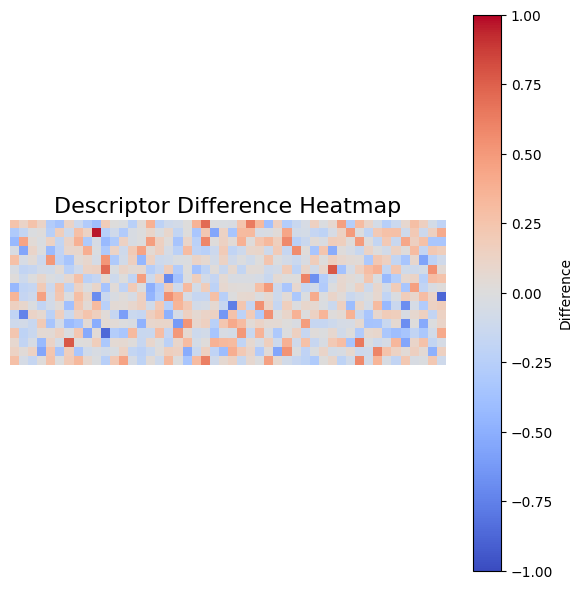

In [245]:
def visualize_descriptor_difference(descriptor1, descriptor2, title="Descriptor Difference Heatmap"):
    """
    Visualizes the difference between two descriptors as a heatmap.
    Args:
        descriptor1: A 1D tensor or numpy array of shape [embedding_dim].
        descriptor2: A 1D tensor or numpy array of shape [embedding_dim].
        title: Title for the heatmap.
    """
    difference = (descriptor1 - descriptor2).view(16, -1).cpu().detach().numpy()
    plt.figure(figsize=(6, 6))
    plt.title(title, fontsize=16)
    plt.imshow(difference, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Difference")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize descriptor differences
visualize_descriptor_difference(des1.squeeze(), des2.squeeze(), title="Descriptor Difference Heatmap")


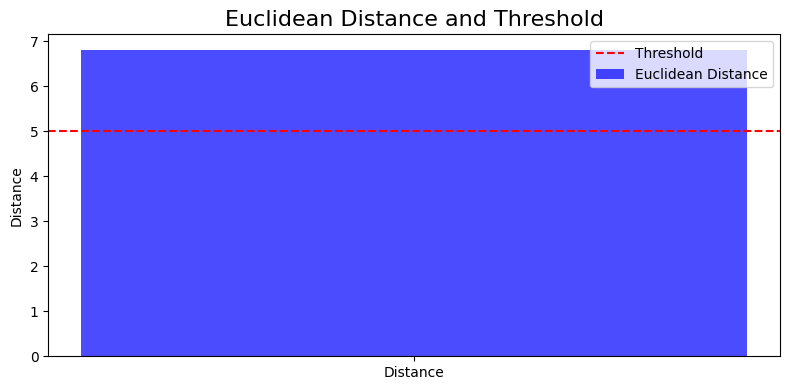

In [246]:
def visualize_euclidean_distance(distance, threshold, title="Euclidean Distance Visualization"):
    """
    Visualizes the Euclidean distance with respect to the threshold.
    Args:
        distance: The computed Euclidean distance.
        threshold: The threshold value to determine the same identity.
        title: Title for the visualization.
    """
    plt.figure(figsize=(8, 4))
    plt.bar(["Distance"], [distance], color="blue", alpha=0.7, label="Euclidean Distance")
    plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold")
    plt.title(title, fontsize=16)
    plt.ylabel("Distance")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize the Euclidean distance
visualize_euclidean_distance(distance_des, threshold=5, title="Euclidean Distance and Threshold")
